<a href="https://colab.research.google.com/github/Minsoo1036/Algorithm-Study/blob/main/Counterfactual_TFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TFT 학습하기

In [1]:
!pip install pytorch_forecasting==1.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.4 MB/s eta 0:00:00


In [2]:
!pip install cmaes

In [3]:
!pip install optuna

In [4]:
!pip install optuna-integration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 kB 3.4 MB/s eta 0:00:00


In [5]:
!pip install lightning==2.4.0

In [26]:
import warnings
import pickle
import copy
import os
import shutil

from sklearn import preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from datetime import datetime, date

#import seaborn as sns
import matplotlib.pyplot as plt

# import tensorflow as tf
#import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

#import seaborn as sns
import matplotlib.pyplot as plt

import warnings
import copy
warnings.filterwarnings(action='ignore')

In [27]:
oracle_df = pd.read_csv("/content/drive/MyDrive/jecheol_coal_counterfactual_df_update.csv")
oracle_df = oracle_df[['Date','Data','d1','d2']]
oracle_df['Date'][0]

'2006-01-01'

In [28]:
oracle_df['Date'] = oracle_df['Date'].map(lambda x : datetime.strptime(x, "%Y-%m-%d").date())

In [29]:
# including test set and real applicable set
oracle_df = oracle_df.loc[oracle_df['Date']>=date(2010,1,1),]
oracle_df = oracle_df.loc[oracle_df['Date']<=date(2022,12,31),]

In [30]:
# train + validation set
total_df = oracle_df.loc[oracle_df['Date']>=date(2010,1,1),]
total_df = total_df.loc[total_df['Date']<=date(2018,8,31),]

In [31]:
total_df = total_df.rename(columns = {'Date':'date',
                                      'Data':'data'})

In [32]:
#total_df = total_df.reset_index()
total_df['date'] = total_df['date'].map(lambda x : datetime.combine(x, datetime.min.time()))

In [33]:
total_df = total_df.set_index('date')

In [34]:
earliest_time = total_df.index.min()

total_df_list = []

for label in total_df:

    if label == "data":

        ts = total_df[label]

        start_date = min(ts.fillna(method='ffill').dropna().index)
        end_date = max(ts.fillna(method='bfill').dropna().index)

        active_range = (ts.index >= start_date) & (ts.index <= end_date)
        ts = ts[active_range].fillna(0.)

        tmp = pd.DataFrame({'Y': ts})
        date = tmp.index

        tmp['hours_from_start'] = (date - earliest_time).seconds / 60 / 60 + (date - earliest_time).days * 24
        tmp['hours_from_start'] = tmp['hours_from_start'].astype('int')

        tmp['days_from_start'] = (date - earliest_time).days
        tmp['date'] = date
        tmp['consumer_id'] = label
        tmp['hour'] = date.hour
        tmp['day'] = date.day
        tmp['day_of_week'] = date.dayofweek
        tmp['month'] = date.month
        tmp['year'] = date.year

        #stack all time series vertically
        total_df_list.append(tmp)

    else:
        total_df_list.append(total_df[label])

time_df = pd.concat(total_df_list,axis=1).reset_index(drop=True)
time_df['hours_from_start'] = pd.Series(np.array([i for i in range(time_df.shape[0])]))

In [35]:
time_df

,Y,hours_from_start,days_from_start,date,consumer_id,hour,day,day_of_week,month,year,d1,d2
0,192.500,0,0,2010-01-01,data,0,1,4,1,2010,5691.0,88.193
1,224.000,1,31,2010-02-01,data,0,1,0,2,2010,5213.0,90.285
2,232.500,2,59,2010-03-01,data,0,1,0,3,2010,5845.0,89.946
3,237.500,3,90,2010-04-01,data,0,1,3,4,2010,5831.0,90.014
4,247.500,4,120,2010-05-01,data,0,1,5,5,2010,5860.0,93.832
...,...,...,...,...,...,...,...,...,...,...,...,...
99,188.305,99,3012,2018-04-01,data,0,1,6,4,2018,8821.0,103.237
100,183.814,100,3042,2018-05-01,data,0,1,1,5,2018,9028.0,106.087
101,198.480,101,3073,2018-06-01,data,0,1,4,6,2018,8976.0,107.359
102,182.245,102,3103,2018-07-01,data,0,1,6,7,2018,9059.0,107.731


In [36]:
#########################################################
seq_len = 12 #input_len
pred_len = 26 #output_len
val_rate = 0.2 #valid_rate

B = total_df.shape[0] - pred_len - seq_len + 1
A = int((1 - val_rate) * (B - pred_len + 1))

max_prediction_length = pred_len
min_prediction_length = pred_len
max_encoder_length = seq_len
training_cutoff = A + pred_len + seq_len - 1
##########################################################
training = TimeSeriesDataSet(
    time_df[lambda x: x.hours_from_start < training_cutoff],
    time_idx="hours_from_start",
    target='Y',
    group_ids=["consumer_id"],
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=min_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["consumer_id"],
    time_varying_known_reals=['d1','d2'],
    time_varying_unknown_reals=['Y'],
    target_normalizer=GroupNormalizer(
        groups=["consumer_id"], transformation="softplus"
    ),  # we normalize by group

    #target_normalizer=MultiNormalizer(
    #    [EncoderNormalizer()]*len(fe_li) ##check this!!
    #   # groups=["consumer_id"]
    #),  # we normalize by group
    add_relative_time_idx=True,
    add_target_scales=False,
    add_encoder_length=False,
    allow_missing_timesteps=False,
)

validation = TimeSeriesDataSet.from_dataset(training, time_df[lambda x: x.hours_from_start >= training_cutoff - seq_len], predict=False, stop_randomization=True)
#test = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)

In [37]:
train_dataloader = training.to_dataloader(train=True, batch_size=32)
val_dataloader = validation.to_dataloader(train=False, batch_size=32)
#total_dataloader = total.to_dataloader(train=False, batch_size=32)

In [38]:
import optuna
from optuna.trial import TrialState
from optuna.integration import PyTorchLightningPruningCallback
from lightning.pytorch import seed_everything

In [40]:
n_trials = 2

def object(trial, training, validation):
    _params = {'gradient_clip_val': trial.suggest_float('gradient_clip_val', 0, 10),
               'hidden_size': trial.suggest_int('hidden_size', 10, 320, step=10),
               'hidden_continuous_size': trial.suggest_int('hidden_continuous_size', 10, 320, step=10),
               'dropout': trial.suggest_float("dropout", 0, 0.5),
               'attention_head_size': trial.suggest_int('attention_head_size', 1, 4),
               #'rnn_layers': trial.suggest_int('rnn_layers', 1, 4),
               'learning_rate': trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True), #trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
               #'rank': trial.suggest_int('rank', 1, 3),
               'batch_size': 2 ** trial.suggest_int('batch_size', 1, 8), #trial.suggest_int('batch_size', 8, 256, step=8)
               }

    #dm.batch_size = _params['batch_size']

    hpo_path = './HPO/'
    # logger = CSVLogger(hpo_path)
    logger = TensorBoardLogger(hpo_path)
    earlystopping = EarlyStopping(monitor="val_loss", patience=7, mode="min")

    _epochs = 10

    trainer = pl.Trainer(max_epochs=_epochs,
                    #devices=gpu,
                    gradient_clip_val=_params['gradient_clip_val'],
                    callbacks=[PyTorchLightningPruningCallback(trial, monitor='val_loss'), earlystopping],
                    logger=logger,
                    enable_checkpointing=False,
                    enable_model_summary=False,
                    enable_progress_bar=False,
                    )

    seed_everything(42, workers=True)
    model = TemporalFusionTransformer.from_dataset(
        training,
        log_interval=10,
#         loss = MultiLoss([MultivariateNormalDistributionLoss(rank=_params['rank']) for _ in range(len(DVAR_config['fe_li']))]), # check this!!
        learning_rate=_params['learning_rate'],
        hidden_size=_params['hidden_size'],
        attention_head_size=_params['attention_head_size'],
        hidden_continuous_size=_params['hidden_continuous_size'],
        output_size=7,
        loss=QuantileLoss(),
        #rnn_layers=_params['rnn_layers'],
        dropout = _params['dropout'],
        reduce_on_plateau_patience=4,
    )
    train_dataloader = training.to_dataloader(train=True, batch_size=_params['batch_size'])
    val_dataloader = validation.to_dataloader(train=False, batch_size=_params['batch_size'])
    trainer.fit(model, train_dataloader, val_dataloader)

    return trainer.callback_metrics['val_loss'].item()

# -----------------------------------------------------------------------------------

# !!!!!!!!!!!!!!!!!!!Need cmaes packapge!!!!!!!!!!!!!!!!!!!
sampler = optuna.samplers.CmaEsSampler(
    restart_strategy="ipop",
    inc_popsize=2,
    seed=42
)
# sampler = optuna.samplers.TPESampler(seed=42)

pruner = optuna.pruners.HyperbandPruner(min_resource=9)
study = optuna.create_study(sampler=sampler, direction='minimize', pruner=pruner)
study.optimize(lambda x: object(x,training, validation), n_trials=n_trials)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

[I 2024-10-10 07:42:53,157] A new study created in memory with name: no-name-93ff498f-7c8b-4b2f-a4f6-c75d61889d1c
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-10-10 07:43:23,741] Trial 0 finished with value: 44.22969055175781 and parameters: {'gradient_clip_val': 3.745401188473625, 'hidden_size': 310, 'hidde

In [41]:
print("Study statistics: ")
print("Number of pruned trials: ", len(pruned_trials))
print("Number of complete trials: ", len(complete_trials))
print("Number of finished trials: ", (len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("=========================================")

params = trial.params
print("params = ", params)

Study statistics: 
Number of pruned trials:  0
Number of complete trials:  2
Number of finished trials:  2
Best trial:
  Value:  44.22969055175781
params =  {'gradient_clip_val': 3.745401188473625, 'hidden_size': 310, 'hidden_continuous_size': 240, 'dropout': 0.2993292420985183, 'attention_head_size': 1, 'learning_rate': 2.0511104188433963e-05, 'batch_size': 1}


In [42]:
params

{'gradient_clip_val': 3.745401188473625,
 'hidden_size': 310,
 'hidden_continuous_size': 240,
 'dropout': 0.2993292420985183,
 'attention_head_size': 1,
 'learning_rate': 2.0511104188433963e-05,
 'batch_size': 1}

In [43]:
import optuna

In [44]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs")

#candi 1 (optuna 3)
#opt_dict = {'gradient_clip_val': 0.21975398647840771, 'hidden_size': 71, 'dropout': 0.22236759230569286, 'hidden_continuous_size': 71, 'attention_head_size': 1, 'learning_rate': 0.0021007460290475475}

#candi 2 (optuna 30)
#opt_dict ={'gradient_clip_val': 0.5651746723889943, 'hidden_size': 72, 'dropout': 0.13494454956109558, 'hidden_continuous_size': 43, 'attention_head_size': 1, 'learning_rate': 0.012790101004929715}
trainer = pl.Trainer(
    #accelerator='gpu', # devices=[0],
    max_epochs=10,
    enable_model_summary=True,
    gradient_clip_val=params['gradient_clip_val'],
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
    log_every_n_steps = 1
)





tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=params['learning_rate'],
    hidden_size=params['hidden_size'],
    attention_head_size=params['attention_head_size'],
    dropout=params['dropout'],
    hidden_continuous_size=params['hidden_continuous_size'],
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)

train_dataloader = training.to_dataloader(train=True, batch_size=2**params['batch_size'])
val_dataloader = validation.to_dataloader(train=False, batch_size=2**params['batch_size'])

import os
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1      | train
3  | prescalers       

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 64.409
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 64.409


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 4.241 >= min_delta = 0.0001. New best score: 60.168
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 4.241 >= min_delta = 0.0001. New best score: 60.168


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 5.930 >= min_delta = 0.0001. New best score: 54.238
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 5.930 >= min_delta = 0.0001. New best score: 54.238


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 5.041 >= min_delta = 0.0001. New best score: 49.197
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 5.041 >= min_delta = 0.0001. New best score: 49.197


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 2.805 >= min_delta = 0.0001. New best score: 46.392
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 2.805 >= min_delta = 0.0001. New best score: 46.392


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 2.000 >= min_delta = 0.0001. New best score: 44.392
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 2.000 >= min_delta = 0.0001. New best score: 44.392


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 1.461 >= min_delta = 0.0001. New best score: 42.931
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 1.461 >= min_delta = 0.0001. New best score: 42.931


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.408 >= min_delta = 0.0001. New best score: 42.523
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.408 >= min_delta = 0.0001. New best score: 42.523


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.525 >= min_delta = 0.0001. New best score: 41.998
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.525 >= min_delta = 0.0001. New best score: 41.998


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.350 >= min_delta = 0.0001. New best score: 41.648
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.350 >= min_delta = 0.0001. New best score: 41.648
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [45]:
trainer.checkpoint_callback.best_model_path

'lightning_logs/lightning_logs/version_0/checkpoints/epoch=9-step=160.ckpt'

In [47]:
pred = np.array(tft.predict(time_df.head(12+26)).cpu())

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [48]:
pred = pred.reshape(-1,1)

In [49]:
real = np.array(time_df.head(12+26).tail(26)['Y'])
real

array([328.35 , 328.   , 327.63 , 326.375, 310.025, 304.773, 305.929,
       295.976, 272.341, 250.2  , 234.833, 227.31 , 219.447, 214.595,
       209.682, 216.1  , 222.409, 224.333, 206.114, 168.238, 145.75 ,
       146.568, 160.19 , 159.325, 165.841, 171.868])

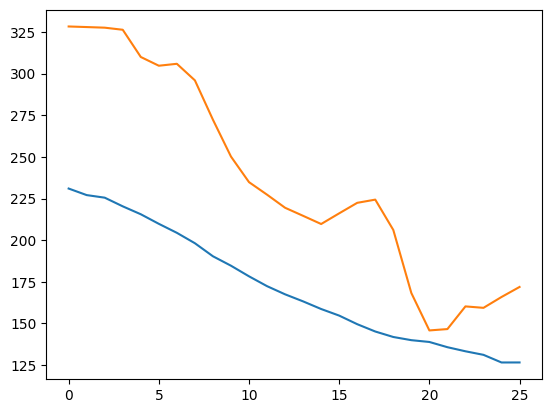

In [50]:
plt.plot(pred)
plt.plot(real)

## Test (Evaluation)

In [52]:
oracle_df = oracle_df.rename(columns = {'Date':'date',
                                      'Data':'data'})

oracle_df['date'] = oracle_df['date'].map(lambda x : datetime.combine(x, datetime.min.time()))

oracle_df = oracle_df.set_index('date')

earliest_time = oracle_df.index.min()

oracle_df_list = []

for label in oracle_df:

    if label == "data":

        ts = oracle_df[label]

        start_date = min(ts.fillna(method='ffill').dropna().index)
        end_date = max(ts.fillna(method='bfill').dropna().index)

        active_range = (ts.index >= start_date) & (ts.index <= end_date)
        ts = ts[active_range].fillna(0.)

        tmp = pd.DataFrame({'Y': ts})
        date = tmp.index

        tmp['hours_from_start'] = (date - earliest_time).seconds / 60 / 60 + (date - earliest_time).days * 24
        tmp['hours_from_start'] = tmp['hours_from_start'].astype('int')

        tmp['days_from_start'] = (date - earliest_time).days
        tmp['date'] = date
        tmp['consumer_id'] = label
        tmp['hour'] = date.hour
        tmp['day'] = date.day
        tmp['day_of_week'] = date.dayofweek
        tmp['month'] = date.month
        tmp['year'] = date.year

        #stack all time series vertically
        oracle_df_list.append(tmp)

    else:
        oracle_df_list.append(oracle_df[label])

time_df = pd.concat(oracle_df_list,axis=1).reset_index(drop=True)
time_df['hours_from_start'] = pd.Series(np.array([i for i in range(time_df.shape[0])]))

In [55]:
time_df.tail(52+12).head(26+12)

,Y,hours_from_start,days_from_start,date,consumer_id,hour,day,day_of_week,month,year,d1,d2
92,204.710,92,2800,2017-09-01,data,0,1,4,9,2017,8344.829,104.155
93,181.638,93,2830,2017-10-01,data,0,1,6,10,2017,8735.993,106.068
94,190.327,94,2861,2017-11-01,data,0,1,2,11,2017,8603.444,106.636
95,239.575,95,2891,2017-12-01,data,0,1,4,12,2017,9066.354,106.116
96,239.705,96,2922,2018-01-01,data,0,1,0,1,2018,9354.000,103.191
97,229.395,97,2953,2018-02-01,data,0,1,3,2,2018,8545.000,102.499
98,218.094,98,2981,2018-03-01,data,0,1,3,3,2018,9506.000,103.160
99,188.305,99,3012,2018-04-01,data,0,1,6,4,2018,8821.000,103.237
100,183.814,100,3042,2018-05-01,data,0,1,1,5,2018,9028.000,106.087
101,198.480,101,3073,2018-06-01,data,0,1,4,6,2018,8976.000,107.359


In [57]:
pred = np.array(tft.predict(time_df.tail(52+12).head(26+12)).cpu())
pred = pred.reshape(-1,1)

real = np.array(time_df.tail(52).head(26)['Y'])
real

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


array([198.176, 218.182, 221.231, 223.322, 198.574, 208.886, 212.255,
       203.975, 207.358, 196.632, 181.964, 155.324, 143.526, 147.962,
       133.639, 135.779, 150.551, 155.174, 158.502, 127.512, 113.766,
       109.832, 110.839, 105.065, 120.338, 122.86 ])

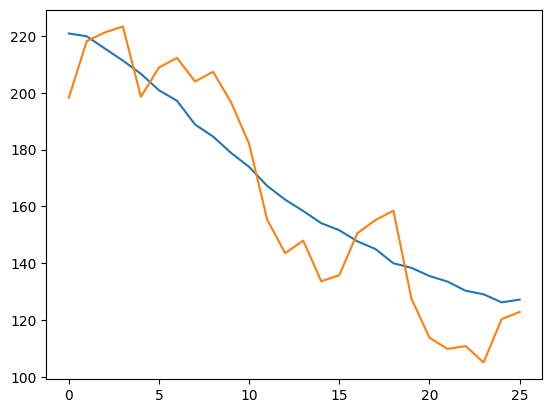

In [58]:
plt.plot(pred)
plt.plot(real)